### Histogram modis


import h5py
import numpy as np
from matplotlib import pyplot as plt
from pathlib import Path
from IPython.display import Image

#### Step 1: define a contrast stretch that takes the range 0-0.6 and maps it to 0-255

In [2]:
left,right = [(0,0.6),(0,255)]
first_stretch=(right[1] - right[0])/(left[1] - left[0])

#### Step 2: define a non-linear stretch that gives the most colors to the darkest pixels

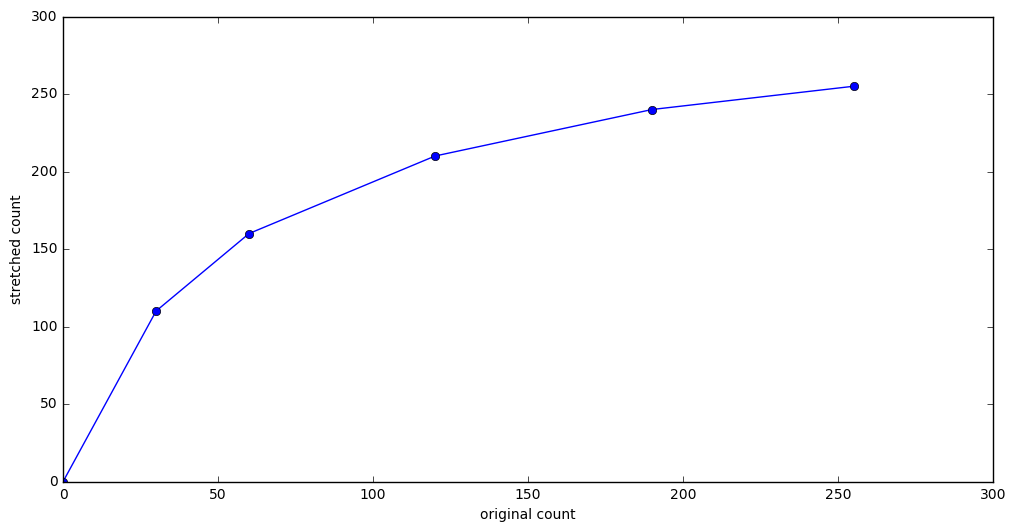

In [3]:
#make five intervals with a different stretch in each interval
stretch=[(0,0),(30,110),(60,160),(120,210),(190,240),(255,255)]
edges=[item[0] for item in stretch]
orig = [item[0] for item in stretch]
%matplotlib inline
stretched = [item[1] for item in stretch]
fig,ax=plt.subplots(1,1,figsize=(12,6))
ax.plot(orig,stretched,'bo-')
ax.set(xlabel='original count',ylabel='stretched count');

Split the range 0-255 into five bins, each with a separate linear  transformation from original to stretched count

In [4]:
stretch_dict={}
for index in np.arange(1,len(stretch)):
    x1,y1=stretch[index]
    x0,y0=stretch[index-1]
    slope=(y1 - y0)/(x1 - x0)
    stretch_dict[index]=(x0,y0,slope)

Now loop throught the three Ft. McMurray channels, applying the two
stretches -- first to make a reflectivity of 0.6 maximum, then
to stretch the 5 intervals

In [5]:
h5_file = 'stiched_out.h5'
test_slice=slice(0,None)
with h5py.File(reproject,'r') as infile:
    chan_dict={}  #holds the pixel values for each channel
    bin_dict={}  #holds the bin number (0 - 6) for each pixel in channel
    for chan in ['1','4','3']:
        print('working on channel {}'.format(chan))
        chan_dict[chan]=infile['channels'][chan][...]
        chan_dict[chan]=chan_dict[chan][test_slice,test_slice]
        avg=np.nanmean(chan_dict[chan].ravel())
        print('channel mean for {} is {}'.format(chan,avg))
        rows,cols = chan_dict[chan].shape
        #
        # stretch to a maximum of 0.6
        #
        int_vals=np.floor(chan_dict[chan]*first_stretch)
        chan_dict[chan]=int_vals.astype(np.int32)
        #
        # now apply the five separate stretches.  Remember that
        # search sorted assigns bin 0 to values below the minimum (0)
        # and bin 6 to values above the maximum (255)
        # 
        #
        bin_dict[chan]=np.searchsorted(edges,chan_dict[chan].ravel())
        print('bins used: ',np.unique(bin_dict[chan]))
        chan_flat=chan_dict[chan].ravel()
        for index,binnum in enumerate(bin_dict[chan][:]):
            if binnum == len(edges):
                chan_flat[index]=255
            elif binnum == 0:
                continue
            else:
                x0,y0,slope = stretch_dict[binnum]
                y= (chan_flat[index] - x0)*slope + y0
                old_val=chan_flat[index]
                chan_flat[index]=y
        #
        # turn the flat channel arrays back into rows,cols
        #
        chan_dict[chan]=chan_flat.reshape(rows,cols)
        #
        # turn the floating point numbers into bytes between 0-255
        #
        chan_dict[chan][...]=np.floor(chan_dict[chan])
        chan_dict[chan]=chan_dict[chan].astype(np.int32)
        hit = chan_dict[chan][...] > 255
        chan_dict[chan][...][hit]=255
        #
        # now all numbers fit into a byte
        #
        chan_dict[chan]=chan_dict[chan].astype(np.uint8)
        avg=np.nanmean(chan_dict[chan].ravel())
        print('stretched mean for {} is {}'.format(chan,avg))
#
# now write the three stretched channels out into a new h5 file
# that can be converted to a tiff
#
tif_file='rbg.tif'

file_dict=read_h5(h5_filename)
chan_list=file_dict['chan_list']
num_chans=len(chan_list)
transform=file_dict['affine_transform']
crs = file_dict['projection_dict']
fill_value = file_dict['fill_value']
height, width = file_dict['channels'][chan_list[0]].shape
data_type=file_dict['channels'][chan_list[0]].dtype
with rasterio.open(tif_filename,'w',driver='GTiff',
                   height=height,width=width,
                   count=num_chans,dtype=data_type,
                   crs=crs,transform=transform,nodata= fill_value) as dst:
    for index,chan_name in enumerate(chan_list):
        result=file_dict['channels'][chan_list[index]][...]
        dst.write(result,index+1)
        dst.update_tags(index+1,name=chan_list[index])
    dst.update_tags(comments=file_dict['comments'])

with h5py.File(stretch_file,'w') as outfile:
    with h5py.File(reproject,'r') as infile:
        groups = infile.keys()
        for the_group in groups:
            group=outfile.create_group(the_group)
            for channel in ['1','4','3']:
                dset=group.create_dataset(channel,chan_dict[channel].shape,dtype=chan_dict[channel].dtype)
                dset[...]=chan_dict[channel][...]
                for item in infile[the_group][channel].attrs.keys():
                    dset.attrs[item]=infile[the_group][channel].attrs[item]
        for item in infile.attrs.keys():
            outfile.attrs[item]=infile.attrs[item]
        outfile.attrs['history']='stretched file written by band_stretch.py'
        outfile.attrs['fill_value']=np.uint8(0)
        
        

working on channel 1
channel mean for 1 is 0.23174114525318146
bins used:  [0 1 2 3 4 5 6]
stretched mean for 1 is 94.89698196540301
working on channel 4
channel mean for 4 is 0.2398623824119568
bins used:  [0 1 2 3 4 5 6]
stretched mean for 4 is 99.75696370668437
working on channel 3
channel mean for 3 is 0.27048665285110474
bins used:  [0 1 2 3 4 5 6]
stretched mean for 3 is 107.63072687383185


#### Converting and histogramming tiff and png files

Convert to tiff with

 python -m a301utils.h5_to_tiff MYD021KM.A2016136.2015.006.stretched.h5 -c 1 4 3
 
 which produces
 
MYD021KM.A2016136.2015.006.stretched_1_4_3.tif

#### Image conversion  -- turning a tif into a png 

Basemap and Jupyter can't display tiffiles, but they can display png files

Use the Python Imaging Library (PIL) to convert from tif to png
(http://pillow.readthedocs.io/en/3.1.x/index.html)

In [54]:
from PIL import Image as pil_image
tiffile=Path('MYD021KM.A2016136.2015.006.stretched_1_4_3.tif')
pngfile=tiffile.with_suffix('.png')
with pil_image.open(str(tiffile)) as input:
    input.save(str(pngfile))


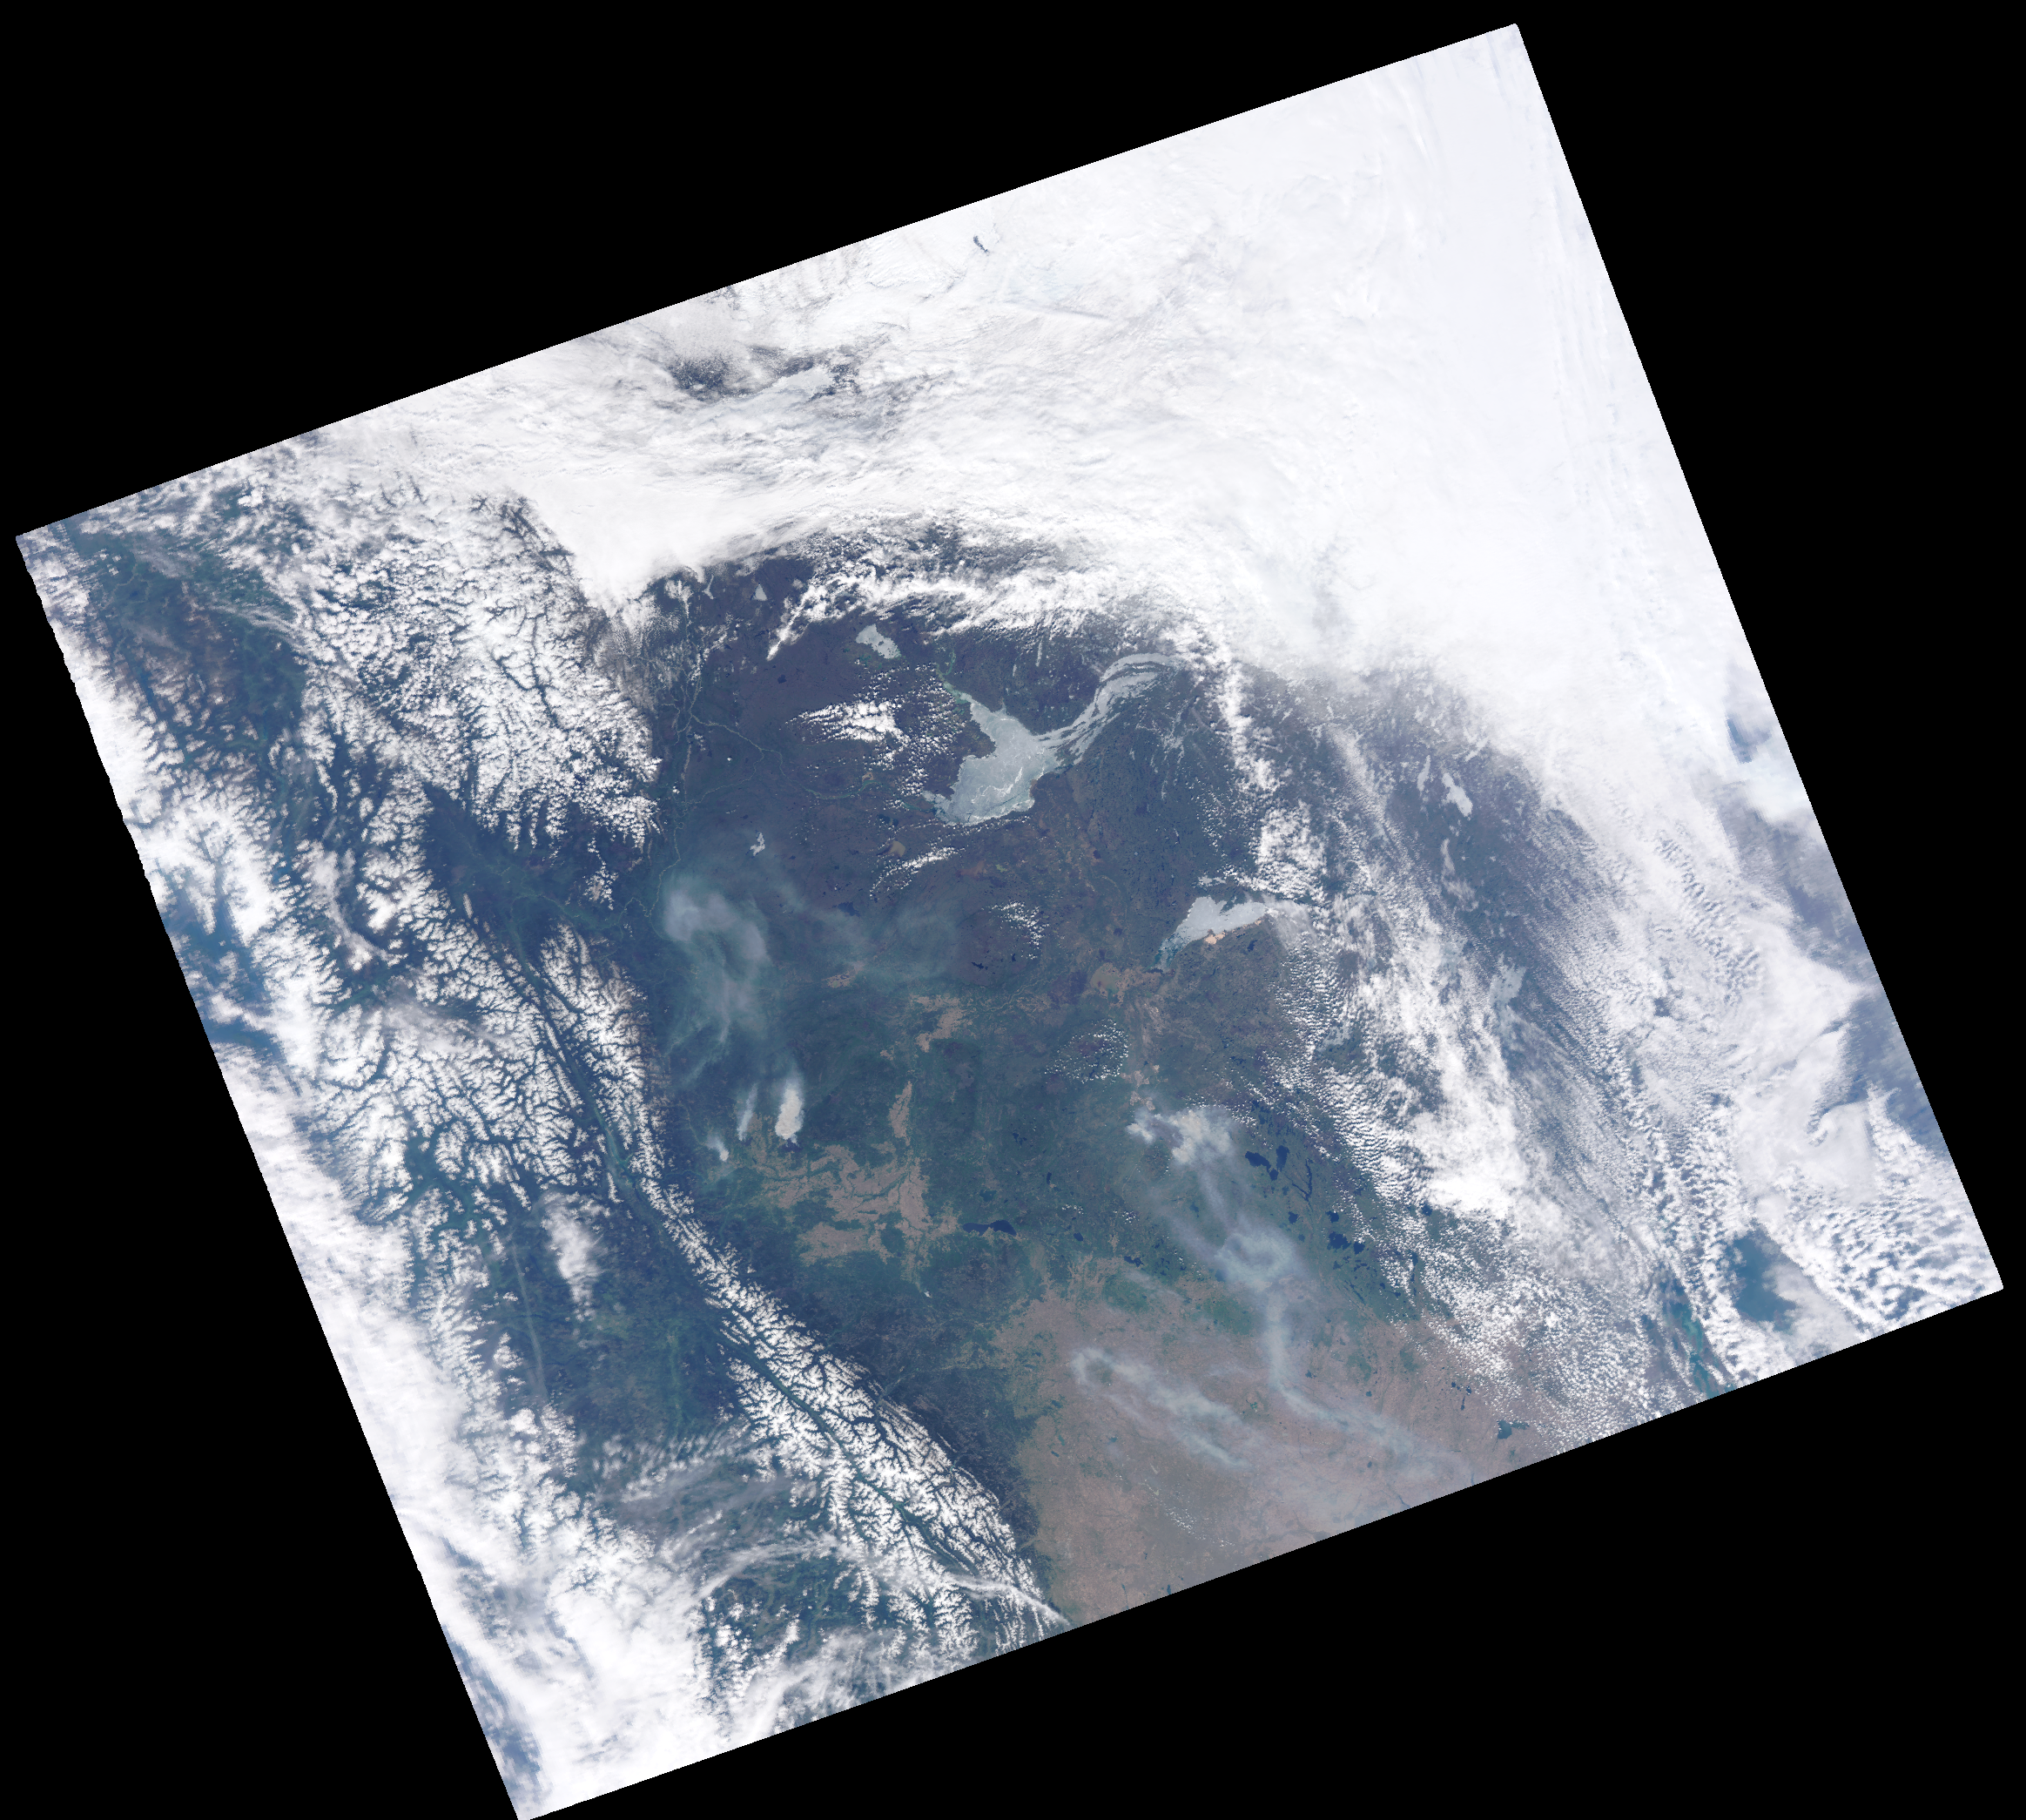

In [7]:
Image(str(pngfile),width=600)

### Reading the r, g, b channels from a tiffile or a pngfile

Use PIL to get the individual stretched channels and histogram them

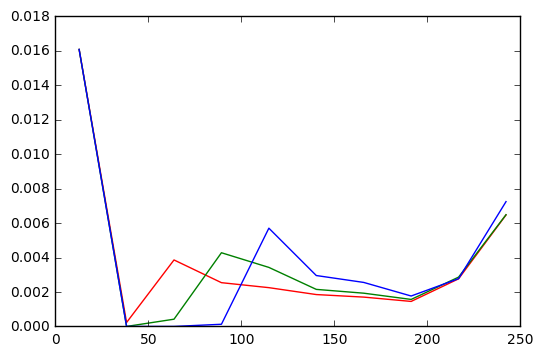

In [8]:
plt.close('all')
#
# extract the bands and convert to a numpy byte array
#
with pil_image.open(str(pngfile)) as input_image:
    bands = input_image.split()
    arrays = [np.asarray(item,dtype=np.uint8) for item in bands]
    r,g,b = arrays
fig, ax = plt.subplots(1,1)
#
# plot the red, green and blue histograms
#
for key,the_array in zip(['r','g','b'],arrays):
    values,edges = np.histogram(the_array.ravel(),normed=True)
    bincens=(edges[1:] + edges[:-1])/2.
    color = '{}-'.format(key)
    ax.plot(bincens,values,color)

### playing with saturation


We can use the [scikit-image](http://scikit-image.org/docs/dev/api/skimage.color.html) color module to play around with rgb and hsv transformations

In [52]:
from skimage import color
#
# open the png file and turn the rgb pixels into hsv pixels
#
# shape will be [height,width,3], where index 0 is hue, index 1 is saturation
# and index 2 is value (brightness)
#
with pil_image.open(str(pngfile)) as input_image:
    hsv_image=color.rgb2hsv(input_image)
#
# set the saturation for every pixel to 100%
#
hsv_image[:,:,1]=1
#
# convert back to rgb
#
rgb_saturated=color.hsv2rgb(hsv_image)
#
# scikit-image uses floating point in the range [0-1]
# convert back to bytes
#
rgb_bytes=np.uint8(rgb_saturated*255)
#
# create a  PIL image from rgb
#
out=pil_image.fromarray(rgb_bytes)
#
# save as png
#
out.save('saturated.png')


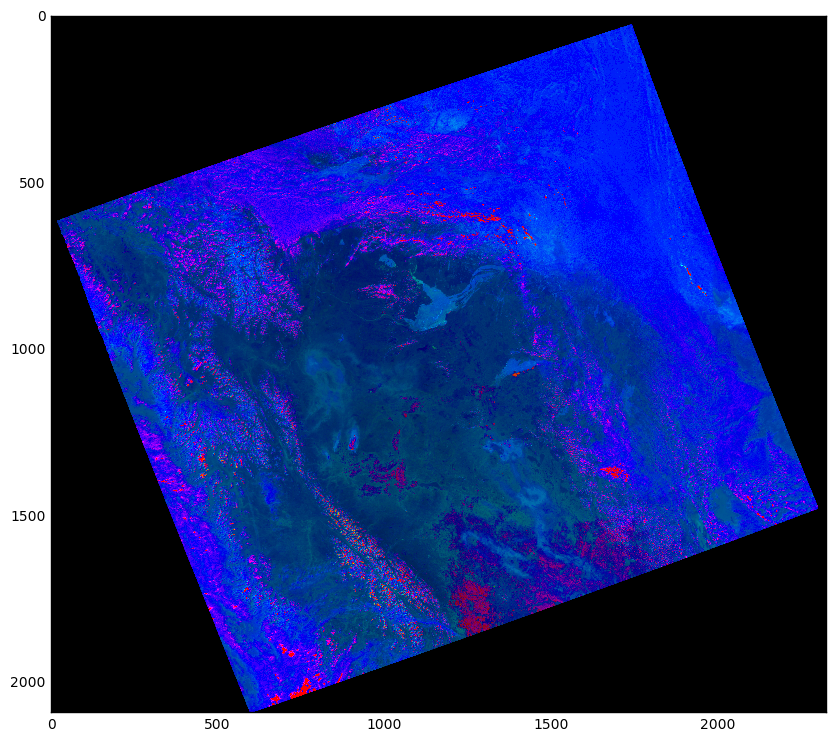

In [53]:
import matplotlib.image as mpimg
saturated_img=mpimg.imread('saturated.png')
fig,ax=plt.subplots(1,1,figsize=(10,10))
ax.imshow(saturated_img.data);